In [1]:
import yfinance as yf
import pandas as pd
import datetime
import numpy as np
import arch 
import matplotlib.pyplot as plt
import random


In [2]:
def fetch_stock_data(ticker,time):
    try:
        stock = yf.Ticker(ticker)
        hist_High = stock.history(period=time)["High"]
        hist_Low = stock.history(period=time)["Low"]
        hist= pd.DataFrame({str(ticker):(hist_Low+hist_High)/2})
        return hist
    except Exception as e:
        print(f"Error fetching data for {ticker}: {e}")
        return None


In [3]:
def Portfolio_Stocks(Stocks):
    Time=pd.date_range(start="01-01-2000",end="01-01-2030",freq="B")
    Stocks_Data=pd.DataFrame({"Nan":"a"*len(Time)},index=Time)
    for i in Stocks:
        data=fetch_stock_data(i,"1y")
        data.index= data.index.strftime('%Y-%m-%d')
        Stocks_Data=pd.concat([Stocks_Data,data],axis=1)
    Stocks_Data=Stocks_Data.iloc[:,1:].dropna()
    return Stocks_Data

def Portfolio_Rets(Stocks_Data, Weights):
    Returns = np.log(Stocks_Data/Stocks_Data.shift(1)).dropna()
    PortfolioReturns = (Returns*Weights).transpose().sum().transpose()
    return pd.DataFrame({"Returns":PortfolioReturns})

def Stock_ret(Stocks_Data): 
    Returns = np.log(Stocks_Data/Stocks_Data.shift(1)).dropna()
    

    


In [4]:
##BSM Call
from scipy.stats import norm

def black_scholes_merton_price(initial_price, strike_price, volatility, risk_free_rate, time_to_maturity):
    # Calculate d1 and d2
    d1 = (np.log(initial_price / strike_price) + (risk_free_rate + 0.5 * volatility**2) * time_to_maturity) / (volatility * np.sqrt(time_to_maturity))
    d2 = d1 - volatility * np.sqrt(time_to_maturity)
    
    # Calculate call and put option prices
    call = (initial_price * norm.cdf(d1) - strike_price * np.exp(-risk_free_rate * time_to_maturity) * norm.cdf(d2))

    return call 



In [5]:
##Define portfolio Parameters
Apple_Q=177.00*4
KO_Q=57.14*7
SPX_Q=394.34*2

Stocks=["AAPL","KO","SXR8.DE"]
Total_Invested= Apple_Q + KO_Q + SPX_Q
Weights=(Apple_Q/Total_Invested,KO_Q/Total_Invested,SPX_Q/Total_Invested )
Stocks_Data=Portfolio_Stocks(Stocks)
Daily_Retuns=Portfolio_Rets(Stocks_Data,Weights)


In [6]:
###Monte Carlo Simulated Projections
#Random Normal

horizon=30

# Initialize variables
horizon = 30

# List to store all projection Series
projections_list = []

# Generate projections and store them in the list
for i in range(1000):
    # Generate random projections
    Projections = np.random.normal(loc=0.0, scale=1.0, size=horizon) / 100
    
    # Initialize the projections price list with the total invested amount
    Projections_Price = [Total_Invested]
    
    # Calculate projected prices
    for j in range(horizon):
        Projections_Price.append((1 + Projections[j]) * Projections_Price[-1])
    
    # Convert to pandas Series and append to list
    projections_list.append(pd.Series(Projections_Price, name=f"path {i}"))

# Concatenate all Series into a single DataFrame
Projections_Data = pd.concat(projections_list, axis=1)

from datetime import datetime

# Get today's date
today_date = datetime.today().date()
Date_projections= pd.date_range(start=today_date, periods=31,freq="B")

Projections_Data.index=Date_projections

# Calculate daily returns for each path
returns = Projections_Data.pct_change().dropna()

# Calculate volatility (standard deviation of returns) for each path
volatilities = returns.std()

# Compute the average volatility across all paths
Volatility = volatilities.mean()

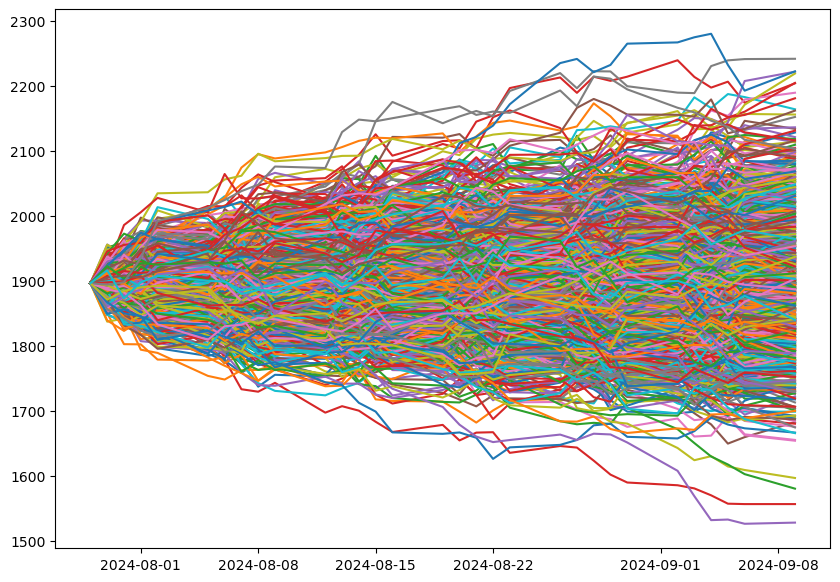

In [7]:
##Plotting Monte Carlo Simulation of the Total invested in the portfolio
plt.figure(figsize=(10, 7))
xx=plt.plot(Projections_Data)


In [8]:
#Getting the Price of a European Call and Puts on the Portfolio as a function of the strike price
rf=0.02 ###Setting to current interest rate
So=Total_Invested
K=Total_Invested
# Volatility has already been defined from the paths of MonteCarlo
Maturity= len(Projections_Data)/365

Call=black_scholes_merton_price(So, K, Volatility, rf, Maturity)
Put= Call - So + K*np.exp(rf*Maturity)

print(f"Price of a Call: {Call}")
print(f"Price of a Put: {Put}")


Price of a Call: 4.16853022849773
Price of a Put: 7.392991872669654


In [9]:
##Finding the Put and Call Prices for different 100 different strike prices
Puts=[]
Calls=[]
lowest_strike=round(Projections_Data.min().min())-1
highest_strike=round(Projections_Data.max().max())+1
for i in range(lowest_strike,highest_strike): 
    call=black_scholes_merton_price(So, i, Volatility, rf, Maturity)
    put= call - So + K*np.exp(rf*Maturity)
    Puts.append(put)
    Calls.append(call)
Calls=pd.DataFrame(Calls)
Puts=pd.DataFrame(Puts)
Puts.index=list(range(lowest_strike,highest_strike))
Calls.index=list(range(lowest_strike,highest_strike))

Options_Prices=pd.concat([Puts,Calls], axis=1)
Options_Prices.columns=["Put Prices","Call Prices"]
Options_Prices


,Put Prices,Call Prices
1526,376.474371,373.249909
1527,375.476068,372.251607
1528,374.477765,371.253304
1529,373.479463,370.255001
1530,372.481160,369.256698
...,...,...
2276,3.224462,0.000000
2277,3.224462,0.000000
2278,3.224462,0.000000
2279,3.224462,0.000000
